# TDOA Localization

The time difference of arrival (TDOA) measurement is given as:

$d = |\vec{a} - \vec{n}| - |\vec{b} - \vec{n}|$

where $\vec{a}$ and $\vec{b}$ are anchor nodes, $\vec{n}$ is the vehicle, and d is the difference in time of arrival of the anchor messages at the vehicle, converted to $m$ using the speed of light.

We are going to linearize this measurement equation and then plot the localization accuracy in a given volume with known anchor locations.

See [Kalman Filtering](https://en.wikipedia.org/wiki/Kalman_filter)

See [Multilateration/TDOA](https://en.wikipedia.org/wiki/Multilateration)

In [1]:
import sympy
from itertools import combinations 
import numpy as np
import matplotlib.pyplot as plt
sympy.init_printing()

def derive_measurement_jacobian():
    a = sympy.Matrix(sympy.symbols('a_0:3', real=True))
    b = sympy.Matrix(sympy.symbols('b_0:3', real=True))
    n = sympy.Matrix(sympy.symbols('n_0:3', real=True))

    d = sympy.Matrix.norm(a - n) - sympy.Matrix.norm(b - n)

    da = sympy.symbols('da')
    db = sympy.symbols('db')


    H = sympy.Matrix([d]).jacobian(n)
    H.simplify()
    H
    f_H = sympy.lambdify((a, b, n), H)
    return {'H': H, 'f_H': f_H}

meas = derive_measurement_jacobian()
meas['H']

⎡                   a₀ - n₀                                     b₀ - n₀       
⎢- ───────────────────────────────────────── + ───────────────────────────────
⎢     ______________________________________      ____________________________
⎢    ╱          2            2            2      ╱          2            2    
⎣  ╲╱  (a₀ - n₀)  + (a₁ - n₁)  + (a₂ - n₂)     ╲╱  (b₀ - n₀)  + (b₁ - n₁)  + (

                               a₁ - n₁                                     b₁ 
──────────  - ───────────────────────────────────────── + ────────────────────
__________       ______________________________________      _________________
        2       ╱          2            2            2      ╱          2      
b₂ - n₂)      ╲╱  (a₀ - n₀)  + (a₁ - n₁)  + (a₂ - n₂)     ╲╱  (b₀ - n₀)  + (b₁

- n₁                                      a₂ - n₂                             
─────────────────────  - ───────────────────────────────────────── + ─────────
_____________________       ______________________

In [2]:
def find_max_error(anchors, n):
    P = 100000*np.eye(3) # this represents that we don't know where we are initially, it is the covariance matrix
    R = (0.2)**2  # the measurement variance
    errors = []
    for a, b in combinations(anchors, 2):
        # if evaluating at an anchor, shift anchor slightly
        if np.linalg.norm(a-n) == 0:
            a = np.array(a) + 1e-6*np.array([1, 1, 1])
        if np.linalg.norm(b-n) == 0:
            b = np.array(b) + 1e-6*np.array([1, 1, 1])
        # Kalman correction
        H = meas['f_H'](a, b, n)
        S = H.dot(P).dot(H.T) + R
        K = P.dot(H.T).dot(np.linalg.inv(S))
        P = P - K.dot(H).dot(P)
    # Find max error standard deviation
    evals, evecs = np.linalg.eig(P)
    return np.sqrt(np.max(evals))

def plot_accuracy(anchors, nz, border=2, vmin=0, vmax=1):
    nx_list = np.linspace(np.min(anchors[:, 0]) - border, np.max(anchors[:, 0]) + border, 20)
    ny_list = np.linspace(np.min(anchors[:, 1]) - border, np.max(anchors[:, 1]) + border, 20)
    levels=np.arange(vmin, vmax + 0.1, 0.1)
    data = []
    for ny in ny_list:
        x_data = []
        for nx in nx_list:
            x_data.append(find_max_error(anchors, [nx, ny, nz]))
        data.append(x_data)
    data = np.array(data)
    X, Y = np.meshgrid(nx_list, ny_list)
    plt.contourf(X, Y, data, cmap='jet', levels=levels, vmin=vmin, vmax=vmax)
    for anchor_id, anchor in enumerate(anchors):
        plt.text(anchor[0]+ 0.1*anchor[2], anchor[1], str(anchor_id))  
        plt.plot(anchor[0], anchor[1], 'kx')
    plt.xlabel('x, m')
    plt.ylabel('y, m')
    cbar = plt.colorbar()
    return plt.gca()

Now we can plot a heat map of the localization accuracy of the method within the flight volume.

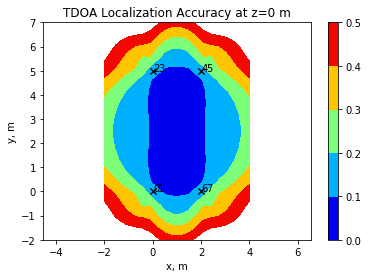

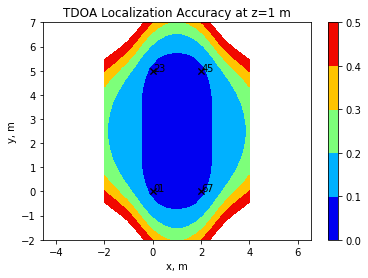

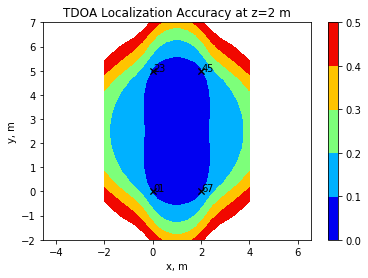

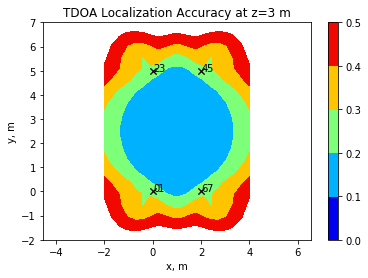

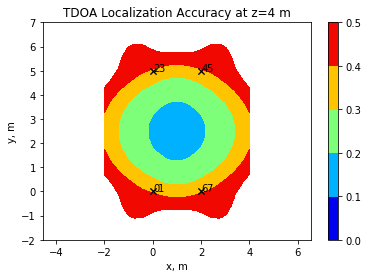

In [3]:
sx = 2
sy = 5
z0 = 0.1
z1 = 2.3
anchors = np.array([
    [0, 0, z0],
    [0, 0, z1],
    [0, sy, z0],
    [0, sy, z1],
    [sx, sy, z0],
    [sx, sy, z1],
    [sx, 0, z0],
    [sx, 0, z1]
])

z_list = [0, 1, 2, 3, 4]
for zi, z in enumerate(z_list):
    border = 2
    plt.figure()
    ax = plot_accuracy(anchors, nz=z, vmin=0, vmax=0.5, border=border)
    plt.title('TDOA Localization Accuracy at z={:g} m'.format(z));
    plt.axis('equal')

We will now try to move some of the anchors back and up and see how this changes the localization accuracy.

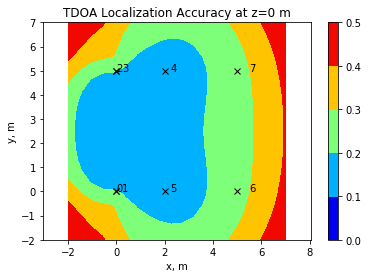

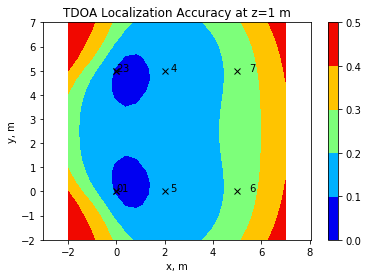

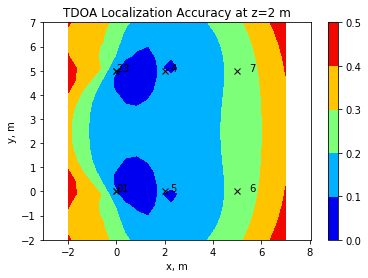

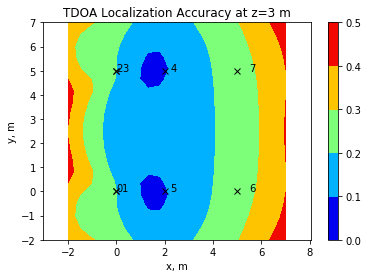

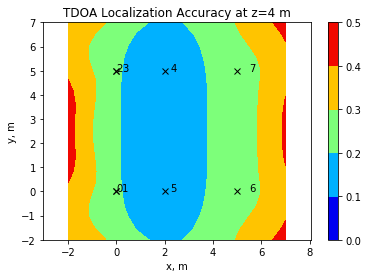

In [4]:
sx = 2
sy = 5
z0 = 0.1
z1 = 2.3
anchors = np.array([
    [0, 0, z0],
    [0, 0, z1],
    [0, sy, z0],
    [0, sy, z1],
    #[sx, sy, z0],
    [sx, sy, z1],
    #[sx, 0, z0],
    [sx, 0, z1],
    [5, 0, 5],
    [5, sy, 5],
    #[10, 0, 10],
    #[10, sy, 10]
])

z_list = [0, 1, 2, 3, 4]
for zi, z in enumerate(z_list):
    plt.figure()
    ax = plot_accuracy(anchors, nz=z, vmin=0, vmax=0.5, border=2)
    plt.title('TDOA Localization Accuracy at z={:g} m'.format(z));
    plt.axis('equal')